# **DERIVING SPATIAL MAPS WITH PYFLWDIR in PYTHON**

# === **RUN WflowRaster.ipynb** ===


In [254]:
print("=== Please run WflowRaster.ipynb")


=== Please run WflowRaster.ipynb


# === **PARAMETERS** ===


In [286]:
# ======= FLAGS =======
Flag_BurnRiver                  = False
Flag_Basins                     = True
Flag_CreateRiver                = True
Flag_Mask                       = True
Flag_Mask_CatchmentSubcatchment = "Subcatchment" # <"Catchment">; <"Subcatchment">

assert Flag_CreateRiver != Flag_BurnRiver

# ======= PATHS =======
Path_Root   = "D:/JOE/MAIN/MODELS/WFLOW/DATA/TimoleagueCrop"
Path_Gis    = "InputGis"
Path_Julia  = "OutputJulia"
Path_Python = "OutputPython"

# ====== FILES NAME =======
# == Input ==
Filename_Input_DemJulia = "Ireland_DEM_Croped.tiff"
Filename_Input_RiverShp = "Timoleague_River3.geojson"

# == Output ==
Filename_Output_Basins_Geojson       = "Basins.geojson"
Filename_Output_Basins_Tiff          = "Basins.tiff"
Filename_Output_Basins_Pits          = "BasinsPits.geojson"
Filename_Output_Catchment            = "Catchment.tiff"
Filename_Output_Catchment_Geojson    = "Catchment.geojson"
Filename_Output_Catchment_Pits       = "CatchmentPits.geojson"
Filename_Output_Dem2Rivers           = "Dem2Rivers.tiff"
Filename_Output_DemCorrected         = "DemCorrected.tiff"
Filename_Python_Ldd_Basins           = "Ldd_Basins.tiff"
Filename_Python_Ldd_Catchment        = "Ldd_Catchment.tiff"
Filename_Python_Ldd_Subcatchment     = "Ldd_Subcatchment.tiff"
Filename_Python_Ldd                  = "Ldd.tiff"
Filename_Output_RiverLength          = "RiverLength.tiff"
Filename_Output_RiverOrder           = "RiverOrder.tiff"
Filename_Output_Slope                = "Slope.tiff"
Filename_Output_Subcatchment         = "Subcatchment.tiff"
Filename_Output_Subcatchment_Geojson = "Subcatchment.geojson"
Filename_Output_Subcatchment_Pits    = "SubcatchmentPits.geojson"
Filename_Output_Floodplains          = "Floodplains.tiff"
Filename_Output_CatchmentSubcatchment = "CatchmentSubcatchment.tiff"

# ======= PARAMETERS =======
# == Ldd inputs ==
# (float, optional) Maximum pour point depth. Depressions with a larger pour point depth are set as pit. A negative value (default) equals an infinitely large pour point depth causing all depressions to be filled.
Param_PitMaxDepth = -1.0

# if Flag_BurnRiver (float) – fixed depth value used to burn in the dem
Param_RiverDepth = 5.0

Param_RiverBurnMethod = "fixed"

Param_RiverOrderMethod = "strahler"  # <"classic"*>  or <"strahler"> or  stream order map. In the classic “bottum up” stream order map, the main river stem has order 1. Each tributary is given a number one greater than that of the river or stream into which they discharge. In the strahler “top down” stream order map, rivers of the first order are the most upstream tributaries or head water cells. If two streams of the same order merge, the resulting stream has an order of one higher. If two rivers with different stream orders merge, the resulting stream is given the maximum of the two order.

# Plotting rivers
Param_RiverOrderMin_Strahler = 4  # Depending on Param_RiverOrderMethod
Param_RiverOrderMax_Classic = 2  # Depending on Param_RiverOrderMethod

# == Other ==
Param_NoData = 255  # Not yet applicable

Param_Crs = 29902  # [-] This is the default projection TM65 / Irish Grid

# The coordinate need to be shifted such that it is in the river network, it is very sensitive
Param_LatLong_Gauge = [146701.41,42082.39]

# TODO: merge with Parameters.jl

print("==== JULIA CODE NEEDS TO BE RUN ====")


==== JULIA CODE NEEDS TO BE RUN ====


# === **UTILS** === 
## == **UTILS:** *Shape -> Vectorize* ==

In [256]:

""" Deltares/pyflwdir/utils.py
https://github.com/Deltares/pyflwdir/blob/main/examples/utils.py """
from rasterio import features
import geopandas as gpd

# convenience method for vectorizing a raster
def GEOPANDA_VECTORIZE(data, nodata, transform, crs, name="value"):
   feats_gen = features.shapes(
      data,
      mask=data != nodata,
      transform=transform,
      connectivity=8,
   )
   feats = [
      {"geometry": geom, "properties": {name: val}} for geom, val in list(feats_gen)
   ]

   # parse to geopandas for plotting / writing to file
   gdf = gpd.GeoDataFrame.from_features(feats, crs=crs)
   gdf[name] = gdf[name].astype(data.dtype)
   return gdf


## == **UTILS:** *Coordinates* ==

In [257]:
import rasterio
import numpy as np

def COORDINATES_2_COLROW(Path_Input, Coordinates):
    with rasterio.open(Path_Input, "r") as src:
        Map = src.read(1)
        nodata = src.nodata
        transform = src.transform
        crs = src.crs
        latlon = src.crs.is_geographic
        prof = src.profile

    # Metadata = rasterio.open(Path_Input)
    X, Y = np.array([Coordinates[0]]), np.array([Coordinates[1]])
    iiY, iiX = src.index(X, Y)
    print([iiX, iiY])

    return [iiX, iiY], Map


In [258]:
import rasterio
import numpy as np

def COLROW_2_COORDINATES(Path_Input, ColRow):
    with rasterio.open(Path_Input, "r") as src:
        Map = src.read(1)
        nodata = src.nodata
        transform = src.transform
        crs = src.crs
        latlon = src.crs.is_geographic
        prof = src.profile

    iiX, iiY = np.array([ColRow[0]]), np.array([ColRow[1]])
    X, Y = src.transform * (iiX, iiY)
    print([X, Y])
    return [X, Y]


## == **UTILS:** *plotting* ==

In [259]:
from matplotlib import pyplot
import matplotlib.cm as cm
from rasterio.plot import show

def PLOT_MAPS(Data, Label, Min, Max, Cmap="viridis"):
   pyplot.imshow(Data, cmap=Cmap, vmin=Min, vmax=Max)
   pyplot.title(Label)
   pyplot.colorbar(label=Label)
   pyplot.show()


## **== UTILS:** *mask*

In [260]:
import numpy as np
import rasterio

def MASK(Path_Input, Path_Output, Subcatchment, NoData=np.nan):

    # Read  data using rasterio
    with rasterio.open(Path_Input, "r") as src:
      Map = src.read(1)
      nodata = src.nodata
      transform = src.transform
      crs = src.crs
      latlon = src.crs.is_geographic
      prof = src.profile

    Nx, Ny = np.shape(Map)

    for iX in range(Nx):
        for iY in range(Ny):
            if Subcatchment[iX, iY] < 1:
                Map[iX, iY] = NoData

    # Write to tiff file
    prof.update(dtype=Map.dtype, nodata=False)
    with rasterio.open(Path_Output, "w", **prof) as src:
        src.write(Map, 1)

    return Map


# === **TOOLS** === 


## == **TOOLS:** *DEM -> Local Drain Direction (LDD)* ==
### = **HYDROMET:** *DEM -> LDD* =

In [261]:
"""Note: This quick solution does require loading the entire flow direction map into memory (Flwdir_D8.load()) which can be a problem for large maps. The implementation inside hydromt_wflow works differently and makes use of options in xarray to perform computations in a chucked way (so loading only chuncks of the maps into memory to perform calculations instead of the whole map)

Derive D8 flow directions grid from an elevation grid.

Outlets occur at the edge of valid data or at user defined cells (if idxs_pit is provided). A local depressions is filled based on its lowest pour point level if the pour point depth is smaller than the maximum pour point depth max_depth, otherwise the lowest elevation in the depression becomes a pit.

Parameters
:
da_elv (2D xarray.DataArray) – elevation raster

max_depth (float, optional) – Maximum pour point depth. Depressions with a larger pour point depth are set as pit. A negative value (default) equals an infinitely large pour point depth causing all depressions to be filled.

outlets ({'edge', 'min', 'idxs_pit'}) – Position of basin outlet(s) If ‘edge’ (default) all valid elevation edge cell are considered. If ‘min’ only the global minimum elevation edge cell is considered and all flow is directed to this cell. If ‘idxs_pit’ the linear indices of the outlet cells are provided in idxs_pit.

idxs_pit (1D array of int) – Linear indices of outlet cells.

gdf_riv (geopandas.GeoDataArray, optional) – River vector data. If provided, the river cells are burned into the dem. Different methods can be used to burn in the river cells, see riv_burn_method.

riv_burn_method ({'uparea', 'rivdph', 'fixed'}, optional) – Method to burn in river vector to aid the flow direction derivation, requires gdf_riv. If ‘fixed’ (default) a fixed river depth rivdph value is used to burn in the river cells. If ‘rivdph’ the rivdph column is used to burn in the river cells directly. If ‘uparea’ the uparea column is used to create a synthetic river depth based on max(1, log10(uparea[m2])).

riv_depth (float) – fixed depth value used to burn in the dem

**kwargs – Additional keyword arguments that are passed to the pyflwdir.dem.fill_depressions() function.

Returns
:
da_flw – D8 flow direction grid
"""

import hydromt
from pyflwdir.core_conversion import d8_to_ldd
import xarray
import numpy as np

def DEM_2_LDD_HYDROMT(
   Path_Input_Dem,
   Path_Output_Ldd,
   Param_PitMaxDepth = Param_PitMaxDepth,
   Param_RiverDepth  = Param_RiverDepth,
   Param_NoData      = Param_NoData,
   outlets           = "min",
   River             = [],
   Idxs_pit          = None,
   Flag_BurnRiver    = Flag_BurnRiver
):
   # Read elevation data using hydromt which will transform the data into xarray
   Dem = hydromt.io.open_raster(Path_Input_Dem)

   # Deriving the D8 from DEM
   if Flag_BurnRiver:
      print("=== Burning rivers ====")

      FlwdirRaster_D8 = hydromt.flw.d8_from_dem(
         da_elv          = Dem,
         max_depth       = Param_PitMaxDepth,
         outlets         = outlets,
         gdf_riv         = River,
         idxs_pit        = Idxs_pit,
         riv_burn_method = "fixed",
         riv_depth       = Param_RiverDepth,
         connectivity    = 8
      )
   else:
      FlwdirRaster_D8 = hydromt.flw.d8_from_dem(
         da_elv       = Dem,
         max_depth    = Param_PitMaxDepth,
         outlets      = outlets,
         idxs_pit     = Idxs_pit,
         connectivity = 8
      )

   # Converting D8-> Ldd as required by WFLOW model
   FlwdirRaster_Ldd = xarray.apply_ufunc(d8_to_ldd, FlwdirRaster_D8.load())

   # Save output
   FlwdirRaster_Ldd.raster.to_raster(Path_Output_Ldd, nodata=Param_NoData)

   return FlwdirRaster_Ldd


### = **PYFLWDIR:** *DEM -> LDD* =

In [262]:
"""
Parameters
:
data (2D array) – digital elevation data

nodata (float, optional) – Missing data value, by default -9999.0

max_depth (float, optional) – Maximum pour point depth. Depressions with a larger pour point depth are set as pit. A negative value (default) equals an infinitely large pour point depth causing all depressions to be filled.

transform (affine transform) – Two dimensional affine transform for 2D linear mapping, by default using the identity transform.

latlon (bool, optional) – True if WGS84 coordinate reference system, by default False. If True it converts the cell areas from degree to metres, otherwise it assumes cell areas are in unit metres.

outlets ({'edge', 'min'}) – Position for basin outlet(s) at the all valid elevation edge cell (‘edge’) or only the minimum elevation edge cell (‘min’)

The underlying fill_depresssions method, see ref API has an argument idxs_pit which you can use to set the outflows (pits) of the raster using it linear index.
You can use the utility function FlwdirRaster.index to get the indices, see ref API

We could expose the idxs_pit argument if from_dem as well if that would help.
"""
import rasterio
import numpy as np
import pyflwdir

def DEM_2_LDD_PYFLWDIR(
    Path_Input_Dem,
    Path_Output_Ldd,
    Param_PitMaxDepth     = Param_PitMaxDepth,
    outlets               = "edge",
    Param_CatchmentMethod = None,
    Param_LatLong_Gauge   = Param_LatLong_Gauge,
):

    # Read elevation data using rasterio
    with rasterio.open(Path_Input_Dem, "r") as src:
        elevtn    = src.read(1)
        nodata    = src.nodata
        transform = src.transform
        crs       = src.crs
        latlon    = src.crs.is_geographic
        prof      = src.profile

    # returns FlwDirRaster object
    Ldd_FlwdirRaster = pyflwdir.from_dem(
        data      = elevtn,
        nodata    = src.nodata,
        max_depth = Param_PitMaxDepth,
        outlets   = outlets,
        transform = transform,
        latlon    = latlon,
    )

    # Add pits to the flow direction raster.
    if Param_CatchmentMethod == "XY":
      X, Y = np.array([Param_LatLong_Gauge[0]]), np.array([Param_LatLong_Gauge[1]])
      Ldd_FlwdirRaster.add_pits(xy=(X, Y))

    Ldd_Array = Ldd_FlwdirRaster.to_array(ftype="ldd")

    # Write to tiff file
    prof.update(dtype=Ldd_Array.dtype, nodata=False)
    with rasterio.open(Path_Output_Ldd, "w", **prof) as src:
        src.write(Ldd_Array, 1)

    return crs, Ldd_Array, Ldd_FlwdirRaster


### = **PCRASTER:** *DEM -> LDD* =

In [263]:
import pcraster as pc

def DEM_2_LDD_PCRASTER(
   Path_Input_Dem,
   Path_Output_Ldd,
   Param_PitMaxDepth=Param_PitMaxDepth,
   Param_RiverDepth=Param_RiverDepth,
   Param_NoData=Param_NoData,
   outlets="min",
   River=[],
   Idxs_pit=None
):
   pc.setglobaloption("lddin")

   Dem = pc.readmap(Path_Input_Dem)

   Ldd_1 = pc.lddcreate(Dem, 0, 0, 0, 0)

   Ldd = pc.lddrepair(Ldd_1)

   pc.report(Ldd, Path_Output_Ldd)
   # Pits = pc.pit(Ldd)

   pc.aguila(Dem)
   pc.aguila(Ldd)

   return Ldd


## == **TOOLS:** *Deriving Rivers network from LDD* ==

In [264]:
import rasterio
import pyflwdir
import numpy as np

def FLOWDIRECTION_2_STREAMS(
   Path_Input_Ldd,
   Path_Output_RiverOrder,
   Path_Output_RiverTrue,
   Param_RiverOrderMax_Classic,
   Param_RiverOrderMin_Strahler,
   Param_RiverOrderMethod,
):
   # === STREAM ORDERS ===================================

   # Read D8 data using rasterio
   with rasterio.open(Path_Input_Ldd, "r") as src:
      FlowDirection_Rasterio = src.read(1)
      nodata                 = src.nodata
      transform              = src.transform
      crs                    = src.crs
      latlon                 = src.crs.is_geographic
      prof                   = src.profile

   FlowDirection_Pyflwdir = pyflwdir.from_array(
      FlowDirection_Rasterio, ftype="ldd", transform=transform, latlon=latlon, cache=True)

   # River order
   Rivers_RiverOrder0 = FlowDirection_Pyflwdir.stream_order(type=Param_RiverOrderMethod)

   # Masking data were River order > Param_RiverOrderMin
   if Param_RiverOrderMethod == "classic":
      Rivers_RiverOrder_Min = 1
   elif Param_RiverOrderMethod == "strahler":
      Rivers_RiverOrder_Min = 2

   Nx, Ny = np.shape(Rivers_RiverOrder0)
   Rivers_RiverOrder = np.ma.empty(shape=(Nx, Ny))
   for iX in range(Nx):
      for iY in range(Ny):
         if Rivers_RiverOrder0[iX, iY] >= Rivers_RiverOrder_Min:
            Rivers_RiverOrder[iX, iY] = Rivers_RiverOrder0[iX, iY]
         else:
            Rivers_RiverOrder[iX, iY] = np.nan

   prof.update(dtype=rasterio.int64, nodata=False)
   with rasterio.open(Path_Output_RiverOrder, "w", **prof) as src:
      src.write(Rivers_RiverOrder, 1)

   # === STREAMS TRUE ==================================
   Rivers_AllTrue = np.ma.empty(shape=(Nx, Ny))
   for iX in range(Nx):
      for iY in range(Ny):
         if Param_RiverOrderMethod == "classic":
            if Rivers_RiverOrder0[iX, iY] <= Param_RiverOrderMax_Classic:
               Rivers_AllTrue[iX, iY] = 1
            else:
               Rivers_AllTrue[iX, iY] = np.nan

         elif Param_RiverOrderMethod == "strahler":
            if Rivers_RiverOrder0[iX, iY] >= Param_RiverOrderMin_Strahler:
               Rivers_AllTrue[iX, iY] = 1
            else:
               Rivers_AllTrue[iX, iY] = np.nan

   prof.update(dtype=rasterio.int64, nodata=False)
   with rasterio.open(Path_Output_RiverTrue, "w", **prof) as src:
      src.write(Rivers_AllTrue, True)

   return Rivers_AllTrue, Rivers_RiverOrder


## == **TOOLS:** *Pits* ==

### = **PITS:** *Detecting* =

In [265]:
def LDD_2_PITS(Ldd, Verbose=False):

   Nx, Ny = np.shape(Ldd)

   Pits = np.ma.empty(shape=(Nx, Ny))
   iPits = 0
   for iX in range(Nx):
      for iY in range(Ny):
         if Ldd[iX, iY] == 5:
            iPits = iPits + 1
            Pits[iX, iY] = 1
            if Verbose:
               print([iX, iY])
         else:
            Pits[iX, iY] = np.nan
   N_Pits = iPits
   print("Number of pits =", iPits)

   PLOT_MAPS(Pits, "Pits", 0, 1,)
   return N_Pits, Pits

# pyflwdir.FlwdirRaster.add_pits
# pyflwdir.FlwdirRaster.repair_loops
# pyflwdir.FlwdirRaster.idxs_ds
# # Linear indices of pits/outlets.
# iiPits_Vector = Ldd_Pyflwdir.idxs_pit


### **== PITS:** *Saving to file* **==**

In [266]:
import geopandas as gpd

def PITS_TOFILE(crs, FlwdirRaster, iXY, Path_Pits):
   X = FlwdirRaster.xy(iXY)[0]
   Y = FlwdirRaster.xy(iXY)[1]

   Pits_Geopanda = gpd.GeoSeries(gpd.points_from_xy(X, Y, crs=crs))

   # Saving
   Pits_Geopanda.to_file(Path_Pits, driver='GeoJSON', mode="w")
   print(Path_Pits)


## = **TOOLS:** *Ldd->Subcatchments* =

In [267]:
'''Parameters:
idxs (array_like, optional) – linear indices of sub(basin) outlets, by default is None.
xy (tuple of array_like of float, optional) – x, y coordinates of sub(basin) outlets, by default is None.
ids (1D array of uint32, optional) – IDs of (sub)basins in same order as idxs, by default None'''

import numpy as np
import geopandas as gpd
import rasterio
import pyflwdir

def FLOWDIRECTION_2_CATCHMENT(
   Path_Input_Ldd,
   Path_Output_Subcatchment,
   Path_Output_Subcatchment_Geojson,
   Name                = "Subcatchment",
   XY                  = Param_LatLong_Gauge,
   idxs                = None,
   Option_Subcatchment = "None"
): # <"XY">, <"idxs">, <"None">

   # Read elevation data using rasterio
   with rasterio.open(Path_Input_Ldd, "r") as src:
      FlowDirection = src.read(1)
      transform = src.transform
      crs = src.crs
      latlon = crs.is_geographic
      prof = src.profile

   Ldd = pyflwdir.from_array(
      FlowDirection, ftype="ldd", transform=src.transform, latlon=crs.is_geographic, cache=True)

   if Option_Subcatchment == "XY":
      X, Y = np.array([XY[0]]), np.array([XY[1]])
      Subcatchment = Ldd.basins(xy=(X, Y))

   elif Option_Subcatchment == "idxs":
      Subcatchment = Ldd.basins(idxs=idxs)

   elif Option_Subcatchment == "None":
        Subcatchment = Ldd.basins()

   # Save output to tiff
   prof.update(dtype=Subcatchment.dtype, nodata=False)

   with rasterio.open(Path_Output_Subcatchment, "w", **prof) as src:
      src.write(Subcatchment, 1)

   # Write output to GeoJSON file
   Subcatchment_Geopanda = GEOPANDA_VECTORIZE(Subcatchment.astype(
      np.int32), np.nan, transform=transform, crs=crs, name=Name)

   Subcatchment_Geopanda.to_file(
      Path_Output_Subcatchment_Geojson, driver='GeoJSON', mode="w")

   print(Path_Output_Subcatchment_Geojson)

   return Subcatchment, Subcatchment_Geopanda


## == **TOOLS:** *Adjusting DEM* ==

In [268]:
import pyflwdir
import rasterio
import os as os

"""Returns the hydrologically adjusted elevation where each downstream cell has the same or lower elevation as the current cell, based on Yamazaki et al. (2012)"""

def DEM_ADJUST(Path_Input_Dem, Path_Input_Ldd, Path_Output_DemCorrected):
   # Read uncoreccted DEM data using rasterio
   with rasterio.open(Path_Input_Dem, "r") as src:
      Dem_Uncorrected = src.read(1)
      nodata          = src.nodata
      transform       = src.transform
      crs             = src.crs
      latlon          = src.crs.is_geographic
      prof            = src.profile

   # Read D8 data using rasterio
   with rasterio.open(Path_Input_Ldd, "r") as src:
      FlowDirection_Rasterio = src.read(1)
      nodata                 = src.nodata
      transform              = src.transform
      crs                    = src.crs
      latlon                 = src.crs.is_geographic
      prof                   = src.profile

   FlowDirection_Pyflwdir = pyflwdir.from_array(FlowDirection_Rasterio, ftype="ldd", transform=transform, latlon=latlon, cache=True)

   Dem_Corrected = FlowDirection_Pyflwdir.dem_adjust(elevtn=Dem_Uncorrected)

   prof.update(dtype=rasterio.float64, nodata=False)
   with rasterio.open(Path_Output_DemCorrected, "w", **prof) as src:
      src.write(Dem_Corrected, 1)

   return Dem_Corrected


## == **TOOLS:** *DEM -> SLOPE* ==

In [269]:
import rasterio
import pyflwdir

"""The slope is calculated on the basis of the dem in a 3 x 3 cell window, using 2nd order partial derivatives. The slope [m/m] is given as the [increase in height] / [distance in horizontal direction]"""


def DEM_2_SLOPE(Path_Input_Dem, Path_Output_Slope):
   # Read elevation data using rasterio
   with rasterio.open(Path_Input_Dem, "r") as src:
      elevtn    = src.read(1)
      nodata    = src.nodata
      transform = src.transform
      crs       = src.crs
      latlon    = src.crs.is_geographic
      prof      = src.profile

   Slope_Pyflwdir = pyflwdir.dem.slope(
      elevtn, nodata=src.nodata, latlon=latlon, transform=transform
   )

   # Write to tiff file
   prof.update(dtype=Slope_Pyflwdir.dtype, nodata=False)
   with rasterio.open(Path_Output_Slope, "w", **prof) as src:
      src.write(Slope_Pyflwdir, 1)

   return Slope_Pyflwdir


## == **TOOLS**: *RiverLength* ==

In [270]:
""" Returns the subgrid river length [m] based on unit catchment Gauge locations.
      A cell's subgrid river is defined by the path starting at the unit
      catchment Gauge pixel moving up- or downstream until it reaches the next
      Gauge pixel. If moving upstream and a pixel has multiple upstream neighbors,
      the pixel with the largest upstream area is selected.

      Parameters
      ----------
      idxs_out : 2D array of int
         Linear indices of unit catchment Gauges. If None (default) the cell
         size (instead of subgrid length) will be used.
      mask : 2D array of bool with self.shape, optional
         True for valid pixels. can be used to mask out pixels of small rivers.
      direction : {"up", "down"}
         Flow direction in which river length is measured, by default 'up'.
      unit : {'m', 'cell'}
         Upstream area unit.

      Returns
      -------
      rivlen : 2D array of float with idxs_out.shape
         subgrid river length [m]
      """

import pyflwdir

def RIVER_LENGTH(Path_Input_Ldd, Path_Output_RiverLength):

   # Read D8 data using rasterio
   with rasterio.open(Path_Input_Ldd, "r") as src:
      FlowDirection_Rasterio = src.read(1)
      nodata = src.nodata
      transform = src.transform
      crs = src.crs
      latlon = src.crs.is_geographic
      prof = src.profile

   FlowDirection_Pyflwdir = pyflwdir.from_array(
      FlowDirection_Rasterio, ftype="ldd", transform=transform, latlon=latlon, cache=True)

   River_Length = FlowDirection_Pyflwdir.subgrid_rivlen(
      idxs_out=None, mask=None, direction='up', unit='m')

   prof.update(dtype=rasterio.float64, nodata=False)
   with rasterio.open(Path_Output_RiverLength, "w", **prof) as src:
      src.write(River_Length, 1)

   return River_Length


## == **TOOLS:** *Floodplains*==

In [271]:
def FLOODPLAINS(Path_Input_Dem, Path_Output_Floodplain, elevtn, FlwdirRaster, uparea=None, upa_min=0.0, b=0.3):
    # Read uncoreccted DEM data using rasterio
    with rasterio.open(Path_Input_Dem, "r") as src:
        Dem_Uncorrected = src.read(1)
        nodata          = src.nodata
        transform       = src.transform
        crs             = src.crs
        latlon          = src.crs.is_geographic
        prof            = src.profile

    Floodplain = FlwdirRaster.floodplains(elevtn, uparea=uparea, b=b, upa_min=upa_min)

    prof.update(dtype=rasterio.float64, nodata=False)
    with rasterio.open(Path_Output_Floodplain, "w", **prof) as src:
      src.write(Floodplain, 1)

    return Floodplain


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# **=== RUNNING MODEL ===**

## == **RUNNING:** *ldd* ==

### = **Ldd:** *Basins* =

==Ldd Pyflwdir Basins==
Number of pits = 707


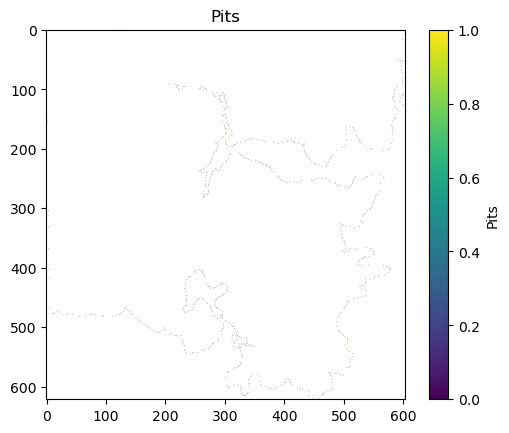

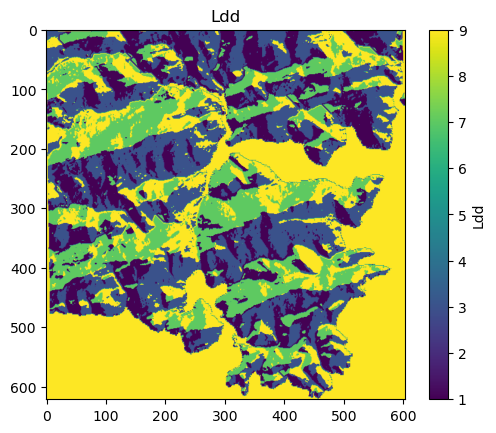

D:/JOE/MAIN/MODELS/WFLOW/DATA/TimoleagueCrop\OutputPython\BasinsPits.geojson


In [272]:
import os as os

Path_Input_Dem           = os.path.join(Path_Root, Path_Julia, Filename_Input_DemJulia)
Path_Output_Ldd_Basins   = os.path.join(Path_Root, Path_Python, Filename_Python_Ldd_Basins)
Path_Input_River_Geojson = os.path.join(Path_Root, Path_Gis, Filename_Input_RiverShp)
Path_Output_Basins_Pits  = os.path.join(Path_Root, Path_Python, Filename_Output_Basins_Pits)

print("==Ldd Pyflwdir Basins==")
crs, Ldd_Basins, Ldd_BasinsFlwdirRaster = DEM_2_LDD_PYFLWDIR(
   Path_Input_Dem,
   Path_Output_Ldd_Basins,
   outlets               = "edge",
   Param_CatchmentMethod = "None")

if not (Ldd_BasinsFlwdirRaster.isvalid):
   print("========= Ldd_Basins_FlwdirRaster not valid ========")

if Flag_BurnRiver:
   River_Geopandas = geopandas.read_file(Path_Input_River_Geojson)
   Ldd_Basins = DEM_2_LDD_HYDROMT(
      Path_Input_Dem,
      Path_Output_Ldd_Basins,
      Param_PitMaxDepth = Param_PitMaxDepth,
      Param_RiverDepth  = Param_RiverDepth,
      Param_NoData      = Param_NoData,
      outlets           = "edge",
      River             = River_Geopandas,
      Idxs_pit          = None,
      Flag_BurnRiver    = Flag_BurnRiver)
else:
   Ldd_Basins = DEM_2_LDD_HYDROMT(
      Path_Input_Dem,
      Path_Output_Ldd_Basins,
      Param_PitMaxDepth = Param_PitMaxDepth,
      Param_RiverDepth  = Param_RiverDepth,
      Param_NoData      = Param_NoData,
      outlets           = "edge",
      River             = [],
      Idxs_pit          = None,
      Flag_BurnRiver    = Flag_BurnRiver)

N_Pits_Basins, Pits = LDD_2_PITS(Ldd_Basins)

PLOT_MAPS(Ldd_Basins, "Ldd", 1, 9)

# Pits
iiPits_Basins = Ldd_BasinsFlwdirRaster.idxs_pit
PITS_TOFILE(crs, Ldd_BasinsFlwdirRaster, iiPits_Basins, Path_Output_Basins_Pits)


### == **DELINATING:** *bassins* ==

D:/JOE/MAIN/MODELS/WFLOW/DATA/TimoleagueCrop\OutputPython\Basins.geojson


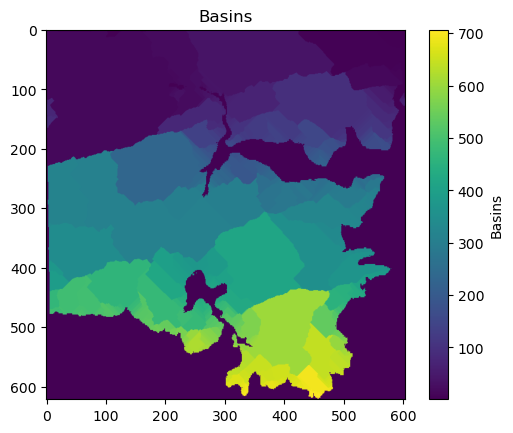

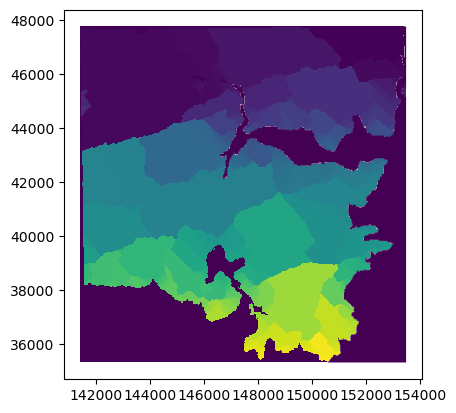

In [273]:
import os as os
# import plot as plt

if Flag_Basins:
    Path_Input_Ldd_Basins       = os.path.join(Path_Root, Path_Python, Filename_Python_Ldd_Basins)
    Path_Output_Basins          = os.path.join(Path_Root, Path_Python, Filename_Output_Basins_Tiff)
    Path_Output_Basins_GeoPanda = os.path.join(Path_Root, Path_Python, Filename_Output_Basins_Geojson)

    Basins, Basins_Geopanda = FLOWDIRECTION_2_CATCHMENT(Path_Input_Ldd_Basins,
                                                        Path_Output_Basins,
                                                        Path_Output_Basins_GeoPanda,
                                                        Name                = "Basins",
                                                        XY                  = Param_LatLong_Gauge,
                                                        idxs                = None,
                                                        Option_Subcatchment = "None" )# <"None">, <"XY">, <"ids">, <"idxs">

    PLOT_MAPS(Basins, "Basins", 1, N_Pits_Basins, Cmap="viridis")
    Basins_Geopanda.plot("Basins")


### == **RUNNING:** *delinating catchment* ==

[264, 284]
Param_SelectCatchment 310
idxs_pit= 170913
Coordinate pit catchment=  [146703.38366107602, 42101.12239566597]
D:/JOE/MAIN/MODELS/WFLOW/DATA/TimoleagueCrop\OutputPython\Catchment.geojson


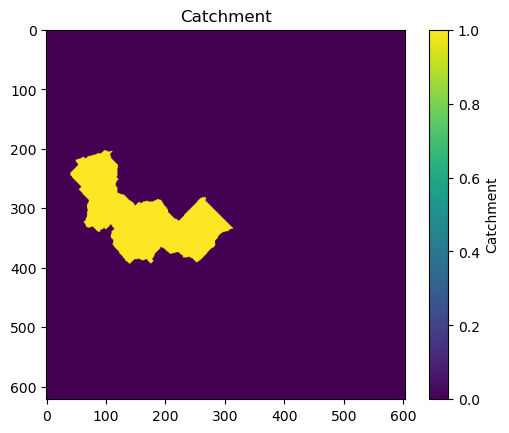

D:/JOE/MAIN/MODELS/WFLOW/DATA/TimoleagueCrop\OutputPython\CatchmentPits.geojson


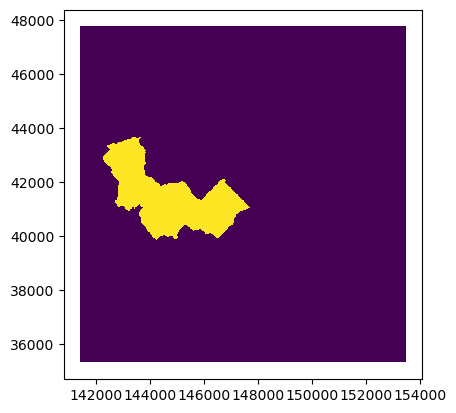

In [283]:
import os as os

Path_Input_Ldd_Basins         = os.path.join(Path_Root, Path_Python, Filename_Python_Ldd_Basins)
Path_Output_Basins            = os.path.join(Path_Root, Path_Python, Filename_Output_Basins_Tiff)
Path_Output_Catchment         = os.path.join(Path_Root, Path_Python, Filename_Output_Catchment)
Path_Output_Catchment_Geojson = os.path.join(Path_Root, Path_Python, Filename_Output_Catchment_Geojson)
Path_Output_Catchment_Pits    = os.path.join(Path_Root, Path_Python, Filename_Output_Catchment_Pits)

# Selecting Catchment which is in the Gauge location
Gauge_ColRow , Maps = COORDINATES_2_COLROW(Path_Output_Basins, Param_LatLong_Gauge)
SelectCatchmentId = Basins[Gauge_ColRow[1], Gauge_ColRow[0]]
print("Param_SelectCatchment", SelectCatchmentId)

idxs_Selected = Ldd_BasinsFlwdirRaster.idxs_pit[SelectCatchmentId - 1]

print("idxs_pit=", iiPits_Basins[SelectCatchmentId - 1])

X = Ldd_BasinsFlwdirRaster.xy(idxs_Selected)[0]
Y = Ldd_BasinsFlwdirRaster.xy(idxs_Selected)[1]

print("Coordinate pit catchment= ", [X , Y] )

Catchment, Catchment_Geopanda = FLOWDIRECTION_2_CATCHMENT(
    Path_Input_Ldd_Basins,
    Path_Output_Catchment,
    Path_Output_Catchment_Geojson,
    Name                = "Catchment",
    XY                  = None,
    idxs                = idxs_Selected,
    Option_Subcatchment = "idxs",
)  # <"None">, <"XY">, <"idxs">

pyplot.imshow(Catchment)

PLOT_MAPS(Catchment, "Catchment", 0, 1, Cmap="viridis")
Catchment_Geopanda.plot("Catchment")

PITS_TOFILE(crs, Ldd_BasinsFlwdirRaster, [idxs_Selected], Path_Output_Catchment_Pits)


### == **RUNNING:** *delinating subcatchment at gauge xy location* ==

Coordinates subcatchment gauge=  [146701.41, 42082.39]
D:/JOE/MAIN/MODELS/WFLOW/DATA/TimoleagueCrop\OutputPython\Subcatchment.geojson


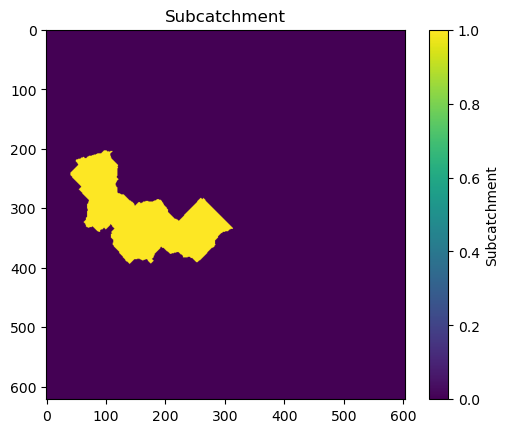

[264, 284]
D:/JOE/MAIN/MODELS/WFLOW/DATA/TimoleagueCrop\OutputPython\SubcatchmentPits.geojson


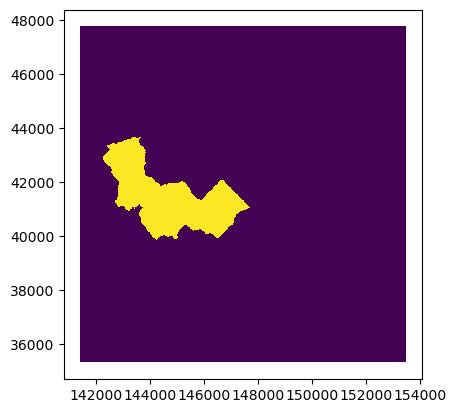

In [284]:
import os as os

Path_Input_Ldd_Basins            = os.path.join(Path_Root, Path_Python, Filename_Python_Ldd_Basins)
Path_Output_Subcatchment         = os.path.join(Path_Root, Path_Python, Filename_Output_Subcatchment)
Path_Output_Subcatchment_Geojson = os.path.join(Path_Root, Path_Python, Filename_Output_Subcatchment_Geojson)
Path_Output_Ldd_Subcatchment     = os.path.join(Path_Root, Path_Python, Filename_Python_Ldd_Subcatchment)
Path_Output_Subcatchment_Pits    = os.path.join(Path_Root, Path_Python, Filename_Output_Subcatchment_Pits)

crs, Ldd_Subcatchment, Ldd_SubcatchmentFlwdirRaster = DEM_2_LDD_PYFLWDIR(
    Path_Input_Dem,
    Path_Output_Ldd_Subcatchment,
    Param_PitMaxDepth     = Param_PitMaxDepth,
    outlets               = "edge",
    Param_CatchmentMethod = "XY",
    Param_LatLong_Gauge = Param_LatLong_Gauge,
)

X = Param_LatLong_Gauge[0]
Y = Param_LatLong_Gauge[1]

print("Coordinates subcatchment gauge= ", [X , Y] )

Subcatchment, Subcatchment_Geopanda = FLOWDIRECTION_2_CATCHMENT(
    Path_Input_Ldd_Basins,
    Path_Output_Subcatchment,
    Path_Output_Subcatchment_Geojson,
    Name                = "Subcatchment",
    XY                  = Param_LatLong_Gauge,
    idxs                = None,
    Option_Subcatchment = "XY",
)  # <"None">, <"XY">, <"idxs">

pyplot.imshow(Subcatchment)

PLOT_MAPS(Subcatchment, "Subcatchment", 0, 1, Cmap="viridis")
Subcatchment_Geopanda.plot("Subcatchment")

# Saving pit location
Gauge_ColRow , Maps = COORDINATES_2_COLROW(Path_Output_Subcatchment, Param_LatLong_Gauge)

assert Ldd_Subcatchment[Gauge_ColRow[1], Gauge_ColRow[0]] == 5
assert Subcatchment[Gauge_ColRow[1], Gauge_ColRow[0]] == 1

Pits_Geopanda = gpd.GeoSeries(gpd.points_from_xy([Param_LatLong_Gauge[0]], [Param_LatLong_Gauge[1]], crs=crs))

Pits_Geopanda.to_file(Path_Output_Subcatchment_Pits, driver='GeoJSON', mode="w")
print(Path_Output_Subcatchment_Pits)


## == **RUNNING:** *DEM -> DEM corrected* ==

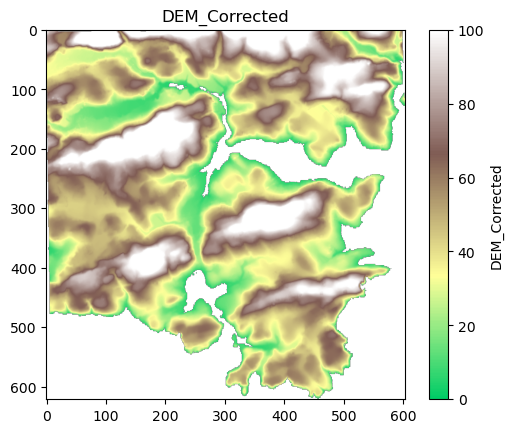

In [276]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors

Path_Input_Dem           = os.path.join(Path_Root, Path_Julia, Filename_Input_DemJulia)
Path_Output_DemCorrected = os.path.join(Path_Root, Path_Python, Filename_Output_DemCorrected)

if Flag_Mask_CatchmentSubcatchment == "Catchment":
    Path_Input_Ldd = os.path.join(Path_Root, Path_Python, Filename_Python_Ldd_Basins)

elif Flag_Mask_CatchmentSubcatchment == "Subcatchment":
    Path_Input_Ldd = os.path.join(Path_Root, Path_Python, Filename_Python_Ldd_Subcatchment)

Dem_Corrected = DEM_ADJUST(Path_Input_Dem, Path_Input_Ldd, Path_Output_DemCorrected)

# PLOTTING
cmap_dem = colors.LinearSegmentedColormap.from_list(
   "dem", plt.cm.terrain(np.linspace(0.25, 1, 400))
)
norm_dem = colors.Normalize(vmin=0, vmax=100)
pyplot.imshow(Dem_Corrected, cmap=cmap_dem, norm=norm_dem)
pyplot.title("DEM_Corrected")
pyplot.colorbar(label="DEM_Corrected")


## == **RUNNING:** *Slope* ==

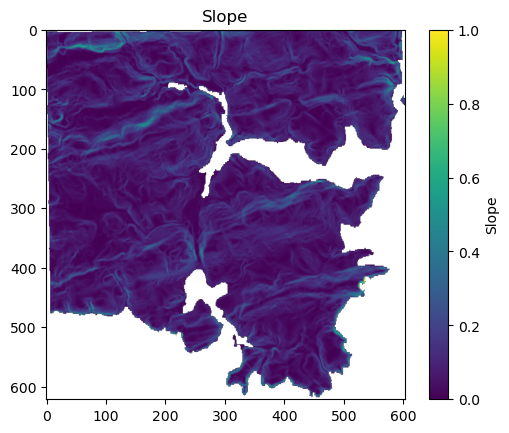

In [277]:
import os as os

Path_Input_DemCorrected = os.path.join(Path_Root, Path_Python, Filename_Output_DemCorrected)
Path_Output_Slope       = os.path.join(Path_Root, Path_Python, Filename_Output_Slope)

Slope_Pyflwdir = DEM_2_SLOPE(Path_Input_DemCorrected, Path_Output_Slope)

PLOT_MAPS(Slope_Pyflwdir, "Slope", 0, 1.0)


## == **RUNNING:** *Streams* ==

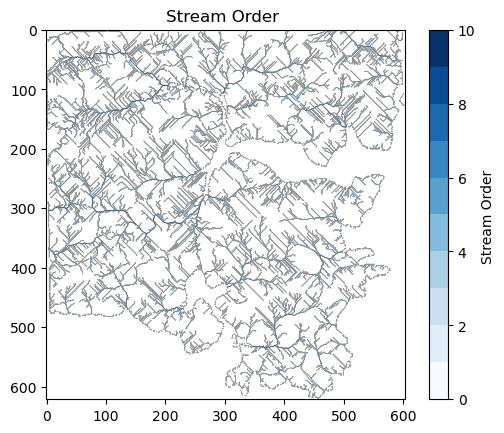

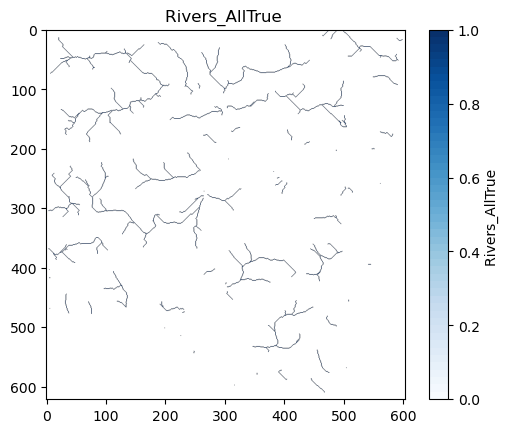

In [278]:

from matplotlib import cm, colors
import matplotlib.pyplot as plt

if Flag_Mask_CatchmentSubcatchment == "Catchment":
    Path_Input_Ldd = os.path.join(Path_Root, Path_Python, Filename_Python_Ldd_Basins)

elif Flag_Mask_CatchmentSubcatchment == "Subcatchment":
    Path_Input_Ldd = os.path.join(Path_Root, Path_Python, Filename_Python_Ldd_Subcatchment)

Path_Output_RiverOrder = os.path.join( Path_Root, Path_Python, Filename_Output_RiverOrder)
Path_Output_RiverTrue  = os.path.join(Path_Root, Path_Python, Filename_Output_Dem2Rivers)

Rivers_AllTrue, Rivers_RiverOrder = FLOWDIRECTION_2_STREAMS(
   Path_Input_Ldd,
   Path_Output_RiverOrder,
   Path_Output_RiverTrue,
   Param_RiverOrderMax_Classic  = Param_RiverOrderMax_Classic,
   Param_RiverOrderMin_Strahler = Param_RiverOrderMin_Strahler,
   Param_RiverOrderMethod       = Param_RiverOrderMethod)

pyplot.imshow(Rivers_RiverOrder, cmap=colors.ListedColormap(
   cm.Blues(np.linspace(0, 1, 10))))

# pyplot.imshow(Rivers_AllTrue , cmap=colors.ListedColormap(
# cm.Blues(np.linspace(0, 1, 10))))

PLOT_MAPS(Rivers_RiverOrder, "Stream Order ", 0, 10,
        Cmap=colors.ListedColormap(cm.Blues(np.linspace(0, 1, 10))))
PLOT_MAPS(Rivers_AllTrue, "Rivers_AllTrue ", 0, 1,
        Cmap=colors.ListedColormap(cm.Blues(np.linspace(0, 1))))


## == **RUNNING:** *river length* ==

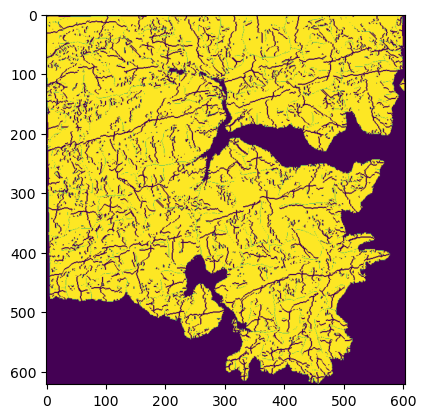

In [279]:

if Flag_Mask_CatchmentSubcatchment == "Catchment":
    Path_Input_Ldd = os.path.join(Path_Root, Path_Python, Filename_Python_Ldd_Basins)

elif Flag_Mask_CatchmentSubcatchment == "Subcatchment":
    Path_Input_Ldd = os.path.join(Path_Root, Path_Python, Filename_Python_Ldd_Subcatchment)

Path_Output_RiverLength = os.path.join(Path_Root, Path_Python, Filename_Output_RiverLength)

River_Length = RIVER_LENGTH(Path_Input_Ldd, Path_Output_RiverLength)

pyplot.imshow(River_Length)


# **== FLOODPLAINS ==**

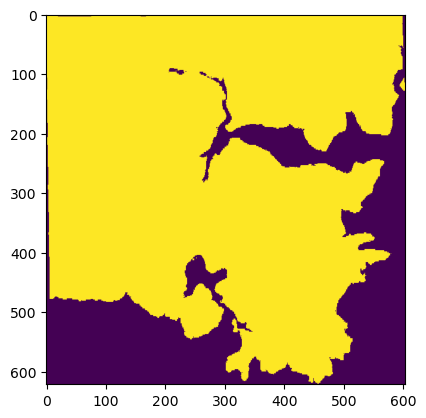

In [280]:
Path_Output_Floodplain = os.path.join(Path_Root, Path_Python, Filename_Output_Floodplains)

if Flag_Mask_CatchmentSubcatchment == "Catchment":
    Floodplains = FLOODPLAINS(Path_Input_Dem, Path_Output_Floodplain, elevtn=Dem_Corrected, FlwdirRaster=Ldd_BasinsFlwdirRaster, b=0.3)

elif Flag_Mask_CatchmentSubcatchment == "Subcatchment":
    Floodplains = FLOODPLAINS(Path_Input_Dem, Path_Output_Floodplain, elevtn=Dem_Corrected, FlwdirRaster=Ldd_SubcatchmentFlwdirRaster, b=0.3)

pyplot.imshow(Floodplains)


# **== MASK ==**

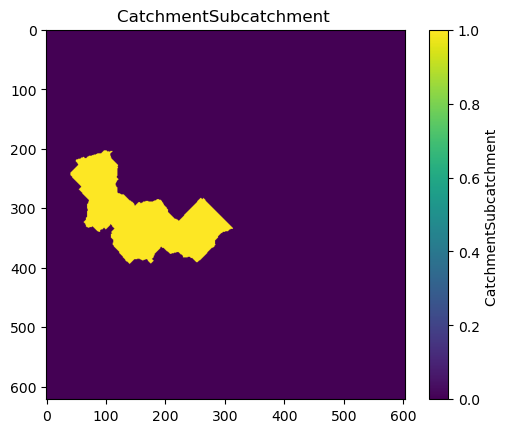

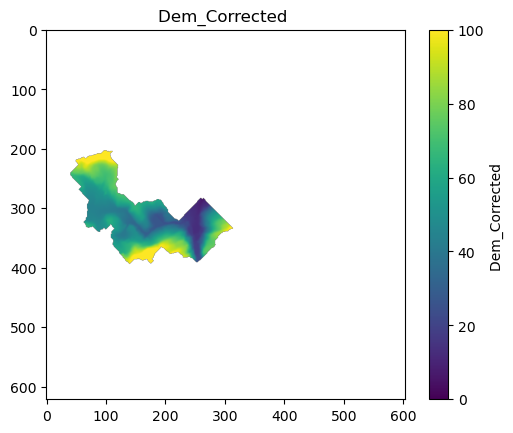

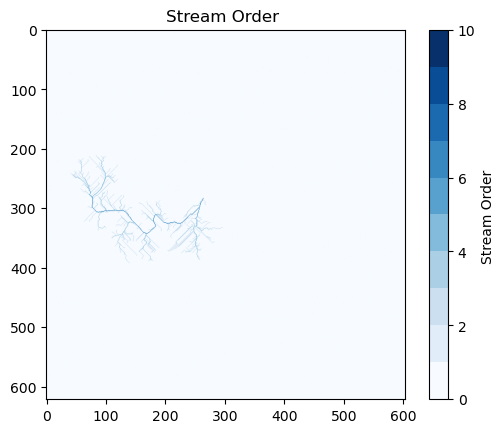

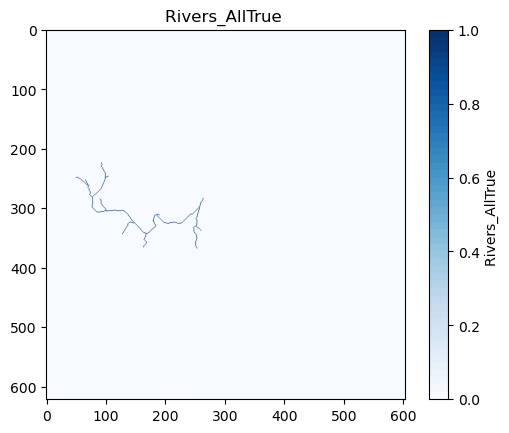

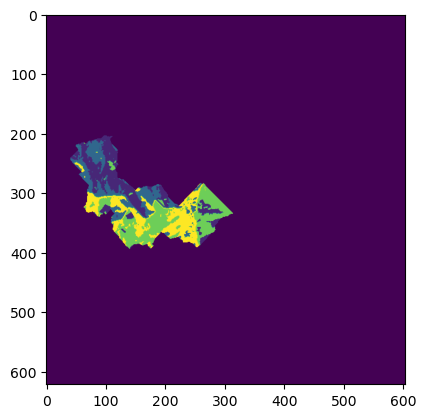

In [287]:
import copy

if Flag_Mask:
    # == CatchmentSubcatchment ==
    Path_Output_CatchmentSubcatchment = os.path.join(Path_Root, Path_Python, Filename_Output_CatchmentSubcatchment)

    if Flag_Mask_CatchmentSubcatchment=="Subcatchment":
        MaskArea                 = copy.deepcopy(Subcatchment)
        Path_Output_Subcatchment = os.path.join(Path_Root, Path_Python, Filename_Output_Subcatchment)
        CatchmentSubcatchment    = MASK(Path_Output_Subcatchment, Filename_Output_CatchmentSubcatchment, MaskArea, NoData=0)

    elif Flag_Mask_CatchmentSubcatchment == "Catchment":
        MaskArea              = copy.deepcopy(Catchment)
        Path_Output_Catchment = os.path.join(Path_Root, Path_Python, Filename_Output_Catchment)
        CatchmentSubcatchment = MASK(Path_Output_Catchment, Filename_Output_CatchmentSubcatchment, MaskArea, NoData=0)

    PLOT_MAPS(CatchmentSubcatchment, "CatchmentSubcatchment ", 0, 1)

    # == Dem corrected ==
    Path_Output_DemCorrected = os.path.join(Path_Root, Path_Python, Filename_Output_DemCorrected)
    Dem_Corrected = MASK(Path_Output_DemCorrected, Path_Output_DemCorrected, MaskArea)
    PLOT_MAPS(Dem_Corrected, "Dem_Corrected ", 0, 100)

    # == River order ==
    Path_Output_RiverOrder = os.path.join( Path_Root, Path_Python, Filename_Output_RiverOrder)
    Rivers_RiverOrder = MASK(Path_Output_RiverOrder, Path_Output_RiverOrder, MaskArea, NoData=0)
    PLOT_MAPS(Rivers_RiverOrder, "Stream Order ", 0, 10,
        Cmap=colors.ListedColormap(cm.Blues(np.linspace(0, 1, 10))))

    # == River true ==
    Path_Output_RiverTrue = os.path.join(Path_Root, Path_Python, Filename_Output_Dem2Rivers)
    Rivers_AllTrue = MASK(Path_Output_RiverTrue, Path_Output_RiverTrue, MaskArea, NoData=0)
    PLOT_MAPS(Rivers_AllTrue, "Rivers_AllTrue ", 0, 1,
        Cmap=colors.ListedColormap(cm.Blues(np.linspace(0, 1))))

    # == River length ==
    Path_Output_RiverLength = os.path.join(Path_Root, Path_Python, Filename_Output_RiverLength)
    River_Length = MASK(Path_Output_RiverLength, Path_Output_RiverLength, MaskArea)
    pyplot.imshow(River_Length)

    # == Slope ==
    Path_Output_Slope = os.path.join(Path_Root, Path_Python, Filename_Output_Slope)
    Slope = MASK(Path_Output_Slope, Path_Output_Slope, MaskArea)
    pyplot.imshow(Slope)

    # == Floodplains ==
    Path_Output_Floodplain = os.path.join(Path_Root, Path_Python, Filename_Output_Floodplains)
    Floodplains = MASK(Path_Output_Floodplain, Path_Output_Floodplain, MaskArea)
    pyplot.imshow(Floodplains)

    # == Ldd ==
    Path_Output_Ldd =  os.path.join(Path_Root, Path_Python, Filename_Python_Ldd)

    if Flag_Mask_CatchmentSubcatchment=="Subcatchment":
        Path_Output_Ldd_Subcatchment     = os.path.join(Path_Root, Path_Python, Filename_Python_Ldd_Subcatchment)
        Ldd = MASK(Path_Output_Ldd_Subcatchment, Path_Output_Ldd,  MaskArea, NoData=0)

    elif Flag_Mask_CatchmentSubcatchment == "Catchment":
        Path_Input_Ldd_Basins         = os.path.join(Path_Root, Path_Python, Filename_Python_Ldd_Basins)
        Ldd = MASK(Path_Input_Ldd_Basins, Path_Output_Ldd,  MaskArea, NoData=0)

    pyplot.imshow(Ldd)



# =========================================================================================================